<a href="https://colab.research.google.com/github/Dhairya-k1/Autonomous-Vehicle-Perception-Module/blob/main/Autonomous_Vehicle_Perception_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHASE 1 : LANE DETECTION

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thomasfermi/lane-detection-for-carla-driving-simulator")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lane-detection-for-carla-driving-simulator' dataset.
Path to dataset files: /kaggle/input/lane-detection-for-carla-driving-simulator


## Load images




In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os

train_data = []
train_labels = []

train_folder_path = os.path.join(path, "train")

for img_name in os.listdir(train_folder_path):
  img_path = os.path.join(train_folder_path, img_name)
  label_path = os.path.join(train_folder_path, img_name,"_label.png")

  if img_path.lower().endswith(('.png', '.jpg', '.jpeg')) and label_path.lower().endswith(('.png', '.jpg', '.jpeg')):
    train_img = cv2.imread(img_path)
    label_img = cv2.imread(label_path)

    if train_img is not None:
      train_data.append(train_img)
      train_labels.append(label_img)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

if(len(train_data)):
  print("Data added sucessfully")
else:
  print("Data not added")

Data added sucessfully


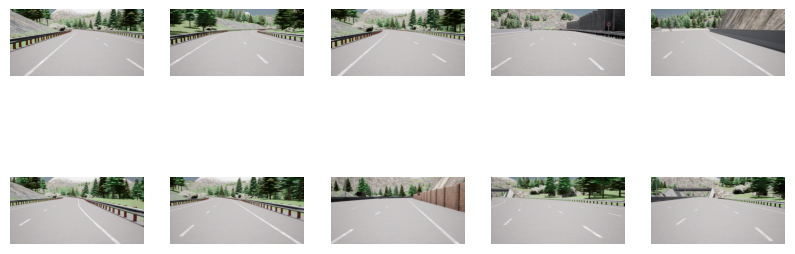

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_data[i])
    plt.axis('off')
plt.show()

##Semantic Segmentation
Semantic segmentation is a computer vision task that assigns a class label to
every pixel in an image, enabling machines to understand visual data at a granular level.

---


Integrating the pytorch-auto-drive repository with the lane-detection-for-carla-driving-simulator Kaggle dataset.



##